In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as cls
import seaborn as sns
import numpy as np
from pathlib import Path
from urllib.parse import urlparse
import glob
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'  # Turns on gridlines by default
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['hatch.linewidth'] = 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
#plt.rcParams['axes.spines.bottom'] = False
#plt.rcParams['axes.spines.left'] = False
plt.rcParams.update({'text.color': "black",
                     'axes.labelcolor': "black"})
okabe_ito_palette = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7', '#000000']
sns.set_palette(okabe_ito_palette)

In [45]:
pd.set_option('display.max_colwidth', None, 'display.max_rows', None)

forum = 'lw'

topic_files = pd.read_csv(f'topics/{forum}/lda_25.csv')

topic_index = 20
n_rows = 20

topic_titles = topic_files[topic_files['dominant_topic'] == topic_index]['title']
sampled_topic_files = topic_titles.sample(n=n_rows)

print(sampled_topic_files)

21912                                                   The mind as a polyviscous fluid
17080                                                       A Good Future (rough draft)
27977                                            What changes should happen in the HHS?
30900                         What We Talk About When We Talk About Objective Functions
14555                                                When Can You Use a Travel Adapter?
2033                     The evolution of superstitious and superstition-like behaviour
17892                                             ChatGPT is our Wright Brothers moment
5502                       What are the claims/arguments made in Eternity in Six Hours?
17010    Tactical Nuclear Weapons Aren't Cost-Effective Compared to Precision Artillery
5276                                             On the Nature of Programming Languages
7365                                                         Demons in Imperfect Search
24195                           

In [46]:
"""Load all CSV files from the folder structure"""
print("Loading data from all CSV files...")

all_files = glob.glob(f"data/{forum}/csv_cleanedwithtopic/**/*.csv", recursive=True)
print(f"Found {len(all_files)} CSV files")

all_data = []
for file in all_files:
    try:
        df = pd.read_csv(file)
        # Extract year and month from filename
        parts = Path(file).stem.split('-')
        if len(parts) >= 2:
            df['year'] = int(parts[0])
            df['month'] = int(parts[1])
        all_data.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not all_data:
    print("No data found! Check your file paths.")

combined_df = pd.concat(all_data, ignore_index=True)
print(f"Loaded {len(combined_df)} total posts from {len(all_data)} files")

# Clean and prepare data
combined_df['postedAt'] = pd.to_datetime(combined_df['postedAt'], errors='coerce')
combined_df['baseScore'] = pd.to_numeric(combined_df['baseScore'], errors='coerce').fillna(0)
combined_df['commentCount'] = pd.to_numeric(combined_df['commentCount'], errors='coerce').fillna(0)

Loading data from all CSV files...
Found 117 CSV files
Loaded 33342 total posts from 117 files


In [47]:
# nice plot templates
!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp

--2025-09-29 19:33:26--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: ‘/tmp/rose-pine-dawn.mplstyle.3’

rose-pine-dawn.mpls 100%[===================>]  39,95K  --.-KB/s    in 0,01s   

2025-09-29 19:33:26 (2,82 MB/s) - ‘/tmp/rose-pine-dawn.mplstyle.3’ saved [40905/40905]



In [48]:
def truncate_colormap(cmap, min_val=0.0, max_val=1.0, n=100):
    """
    Truncate the color map according to the min_val and max_val from the
    original color map.
    """
    new_cmap = cls.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=min_val, b=max_val),
        cmap(np.linspace(min_val, max_val, n)))
    return new_cmap

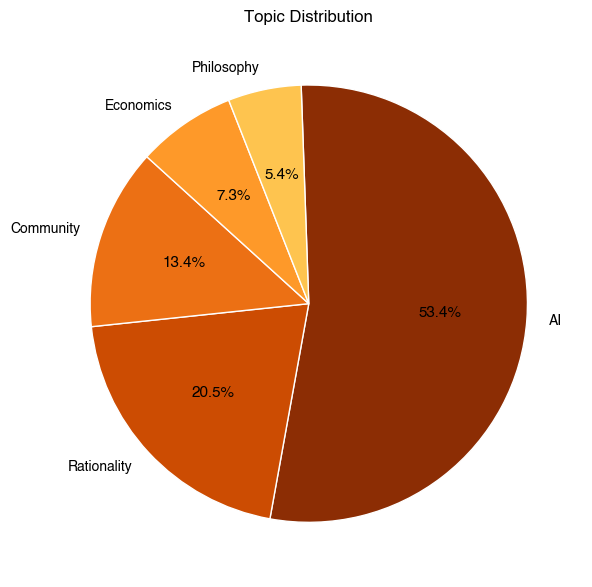

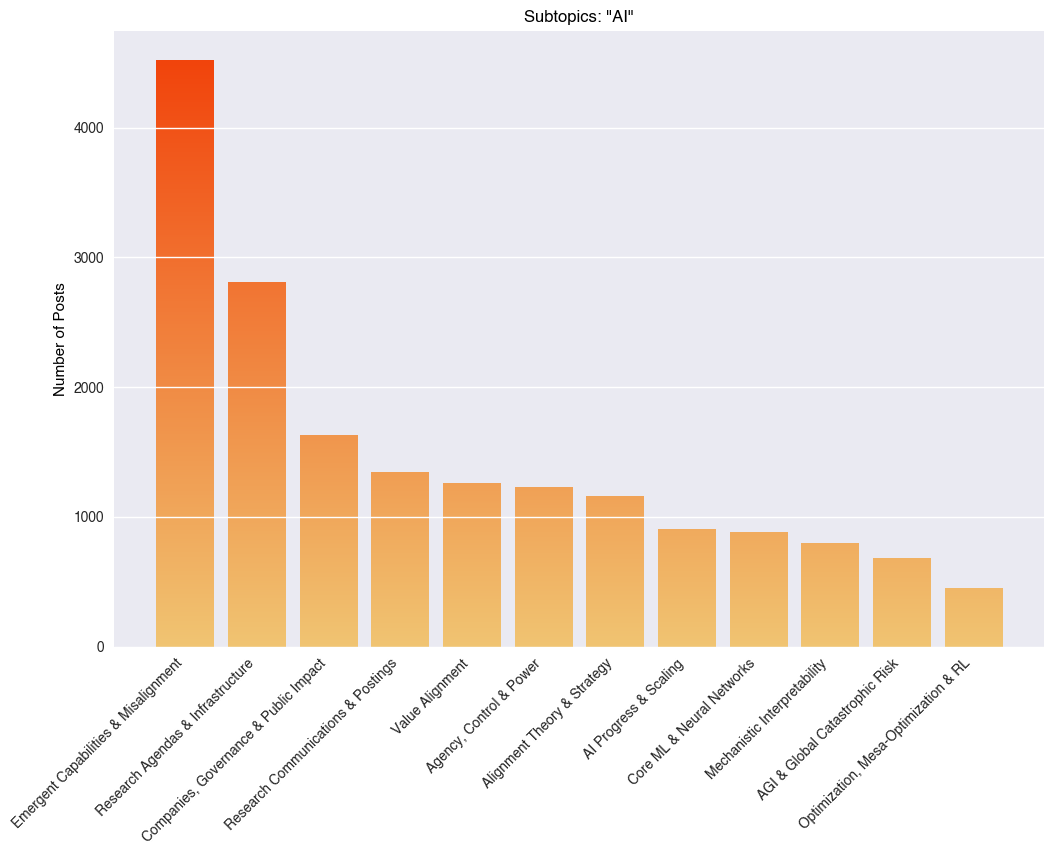

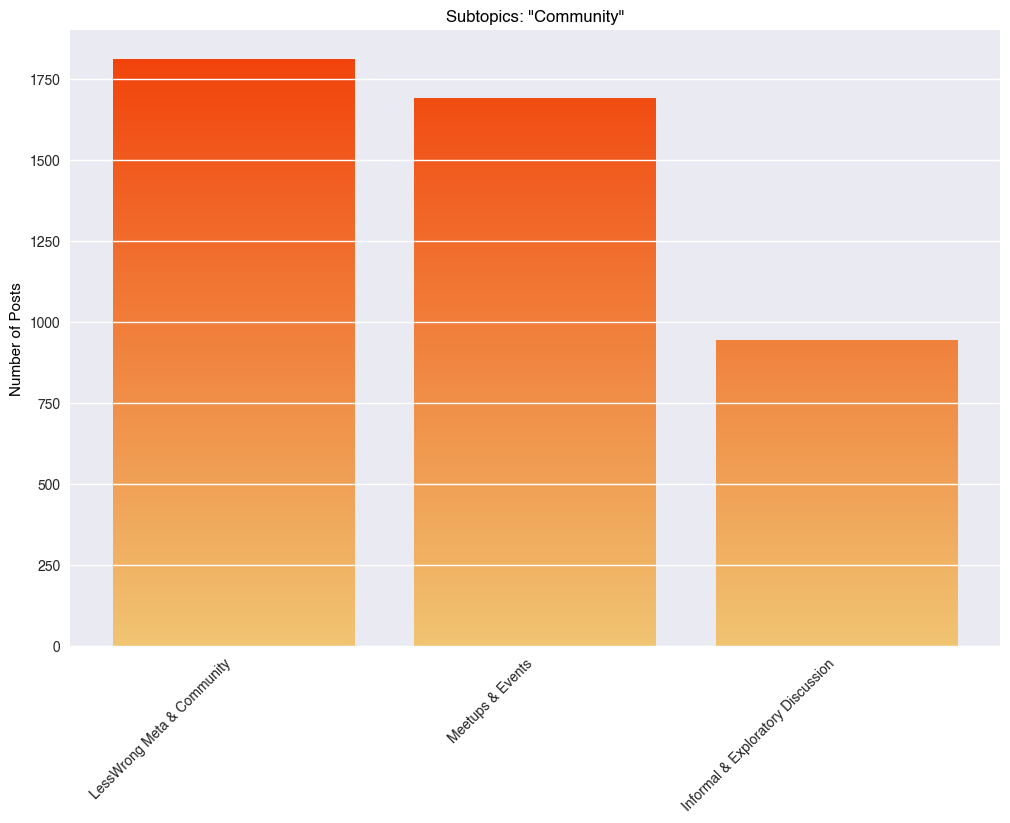

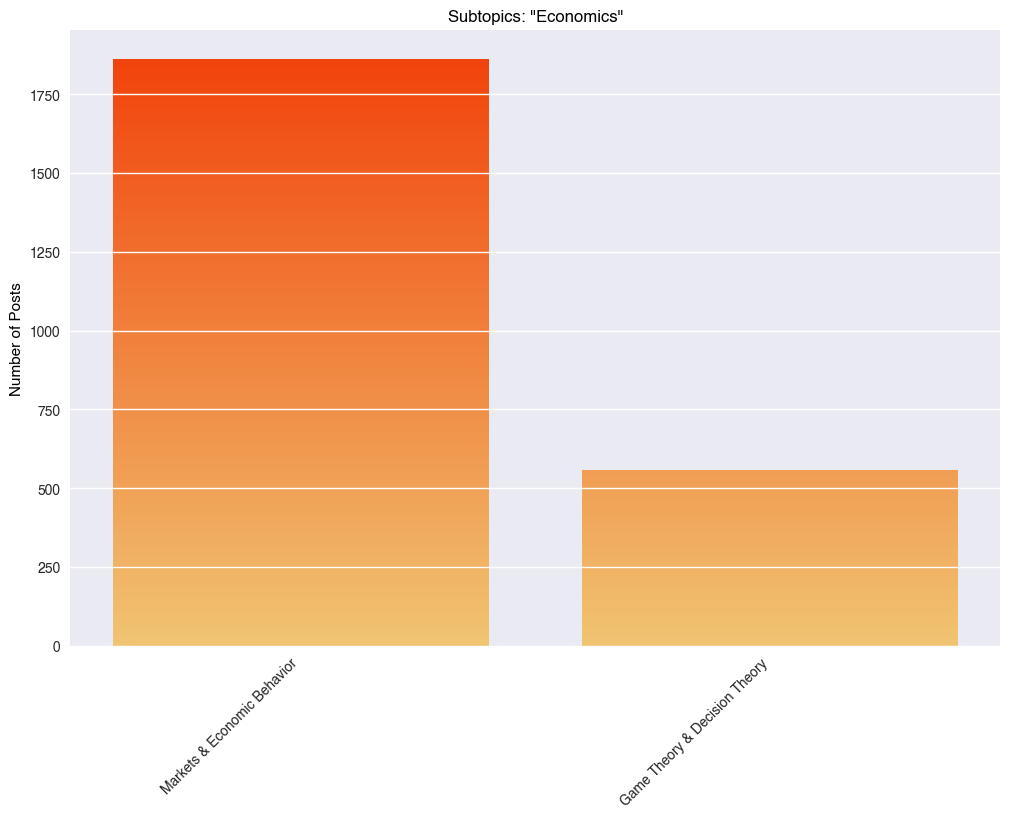

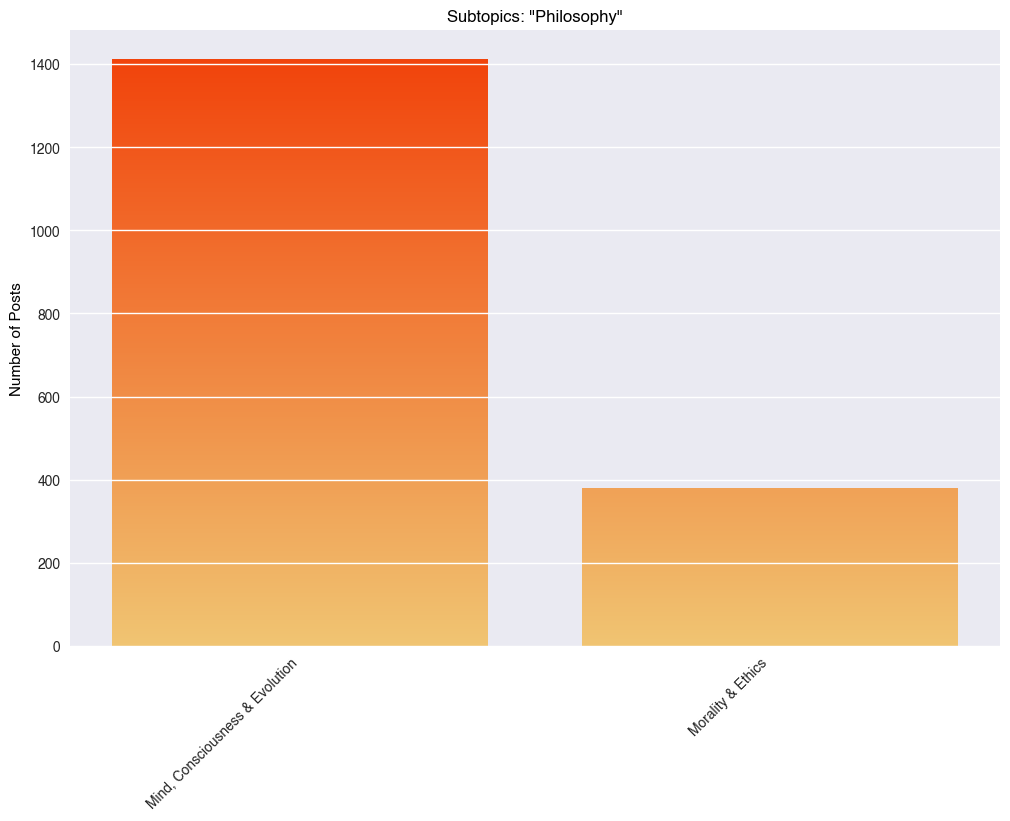

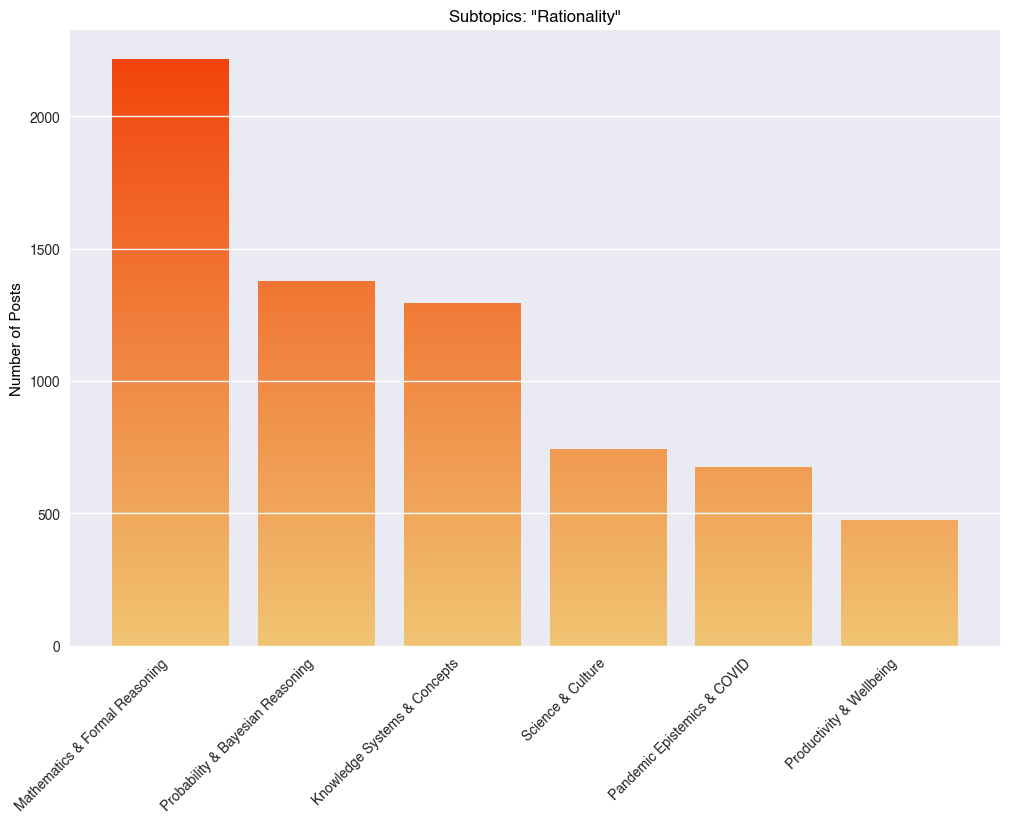

In [49]:
combined_df["super_topic"] = combined_df["topic_label"].str.split(":", n=1).str[0].str.strip()
combined_df["sub_topic"] = combined_df["topic_label"].str.split(":", n=1).str[1].str.strip()

"""=== TOPIC ANALYSIS (Super vs Subtopics) ==="""

# --- Figure 1: Super topic distribution ---
super_counts = combined_df[combined_df["super_topic"] != 'Misc']["super_topic"].value_counts()

plt.figure(figsize=(12, 6))
plt.pie(
    super_counts.values,
    labels=super_counts.index,
    autopct='%1.1f%%',
    startangle=92,
    counterclock=False,
    colors = ["#8c2d04", "#cc4c02", "#ec7014", "#fe9929", "#fec44f", "#fee391", "#fff7bc"],
    wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'}
)
plt.xticks(rotation=45, ha="right")
plt.title("Topic Distribution")
plt.tight_layout()
plt.savefig("img/topic_analysis_super.pdf", dpi=300, bbox_inches="tight")
plt.show()

base_color = "#f23e07"
cmap = LinearSegmentedColormap.from_list("grad_orange", ["#f0c472", base_color])

# Iterate over super_topics
for super_topic, group in combined_df[combined_df["super_topic"] != 'Misc'].groupby("super_topic"):
    sub_counts = group["sub_topic"].value_counts()

    fig, ax = plt.subplots()
    bars = ax.bar(sub_counts.index, sub_counts.values)

    y_min, y_max = ax.get_ylim()
    grad = np.atleast_2d(np.linspace(0, 1, 256)).T
    ax = bars[0].axes  # axis handle
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)  # put the bars in front
        bar.set_facecolor("none")  # make the bars transparent
        x, _ = bar.get_xy()  # get the corners
        w, h = bar.get_width(), bar.get_height()  # get the width and height

        # Define a new color map.
        # For instance, if one bar only takes 10% of the y-axis, then the color
        # map will only use the first 10% of the color map.
        c_map = truncate_colormap(cmap, min_val=0, max_val=(h - y_min) / (y_max - y_min))

        # Let the imshow only use part of the color map
        ax.imshow(grad, extent=[x, x+w, h, y_min], aspect="auto", zorder=0,
                cmap=c_map)
        
    ax.axis(lim)
    ax.set_xticks(range(len(sub_counts)))
    ax.set_xticklabels(sub_counts.index, rotation=45, ha="right")
    ax.set_ylabel("Number of Posts")
    ax.set_title(f'Subtopics: "{super_topic}"')
    plt.savefig(f"img/topic_analysis_sub_{super_topic.replace(' ', '_')}.pdf",
                dpi=300, bbox_inches="tight")
    plt.show()


=== GENDER ANALYSIS ===

Gender Distribution:
Gm: 20,381 (23426.4%)
-: 10,034 (11533.3%)
Gf: 2,407 (2766.7%)


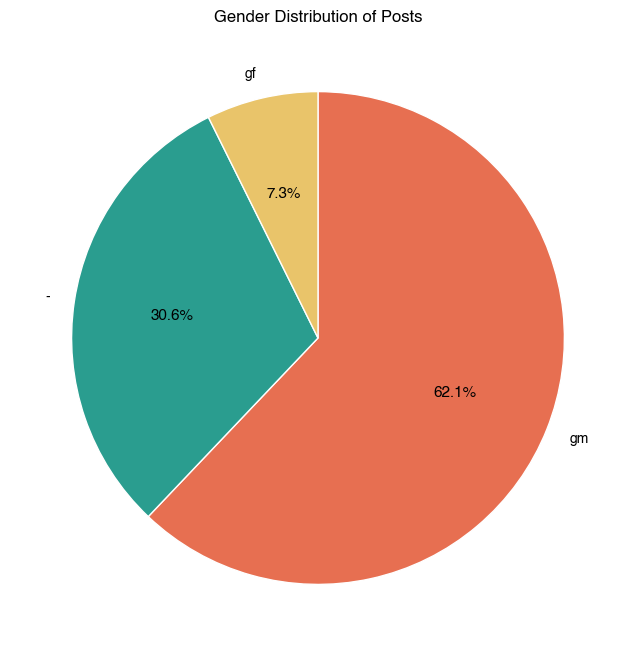

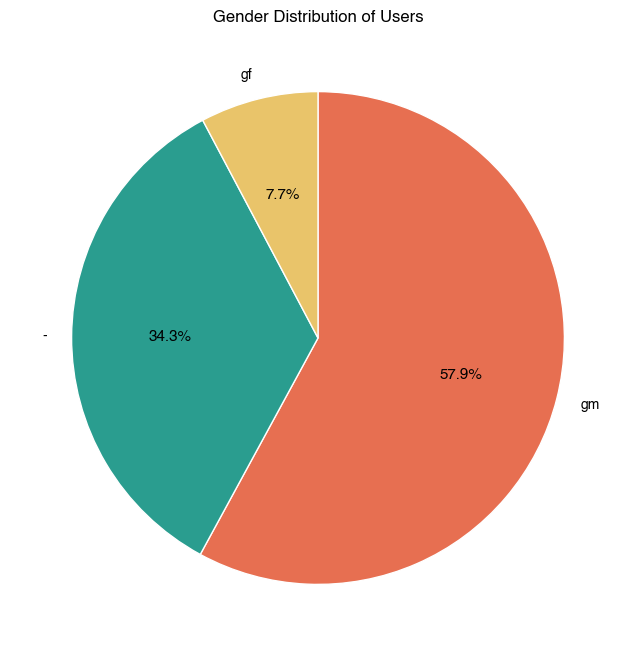

KeyError: 'female'

In [50]:
"""Analyze gender distribution"""
print("\n=== GENDER ANALYSIS ===")

gender_counts = combined_df['user_gender'].value_counts()
print(f"\nGender Distribution:")
for gender, count in gender_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{gender.title()}: {count:,} ({percentage:.1f}%)")

# Gender posts pie chart
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90,
        colors=["#e76f51", "#2a9d8f", "#e9c46a"], 
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'},
        counterclock=False
        )
plt.title('Gender Distribution of Posts')
plt.savefig("img/gender_dist_posts.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Gender users pie chart
# Get unique users with their gender (remove duplicates)
unique_users = combined_df[['user.username', 'user_gender']].drop_duplicates()
user_gender_counts = unique_users['user_gender'].value_counts()

plt.pie(user_gender_counts.values, autopct='%1.1f%%', startangle=90,
        colors=["#e76f51", "#2a9d8f", "#e9c46a"], 
        labels=gender_counts.index,
        wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'},
        counterclock=False
        )
plt.title('Gender Distribution of Users')
plt.savefig("img/gender_dist_users.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Gender distribution by topics
gender_topic = combined_df[combined_df["super_topic"] != 'Misc'].groupby(['super_topic', 'user_gender']).size().unstack(fill_value=0)
gender_topic['total'] = gender_topic['female'] + gender_topic['male'] + gender_topic['unknown']
gender_topic['female_perc'] = (gender_topic['female'] * 100) / gender_topic['total']
gender_topic['male_perc'] = (gender_topic['male'] * 100) / gender_topic['total']
gender_topic['unknown_perc'] = (gender_topic['unknown'] * 100) / gender_topic['total']

gender_perc = gender_topic[['female_perc', 'male_perc', 'unknown_perc']]
gender_perc = gender_perc.rename(columns={'male_perc': 'male', 'female_perc': 'female', 'unknown_perc': 'unknown'})

ax = gender_perc.plot(kind="bar", figsize=(10,6), 
                       color=["#2a9d8f", "#e76f51", "#e9c46a"],
                       stacked=True,
                        )
plt.title('Gender Distribution by Topic')
plt.ylabel('Percentage of Posts')
plt.grid(axis='x')
plt.xlabel('Topic')
plt.legend(title='Gender', bbox_to_anchor=(1,1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("img/gender_posts.pdf", dpi=300, bbox_inches="tight")
plt.show()



=== AUTHOR ANALYSIS ===

Total unique authors: 5,524
Authors with only 1 post: 2,826 (51.2%)
Authors with 10+ posts: 593
Authors with 50+ posts: 97

Top 10 Most Active Authors:
jkaufman: 982 posts
Zvi: 975 posts
Stuart_Armstrong: 484 posts
Raemon: 379 posts
johnswentworth: 366 posts
lsusr: 291 posts
KatjaGrace: 253 posts
jasoncrawford: 238 posts
habryka4: 228 posts
Chris_Leong: 224 posts


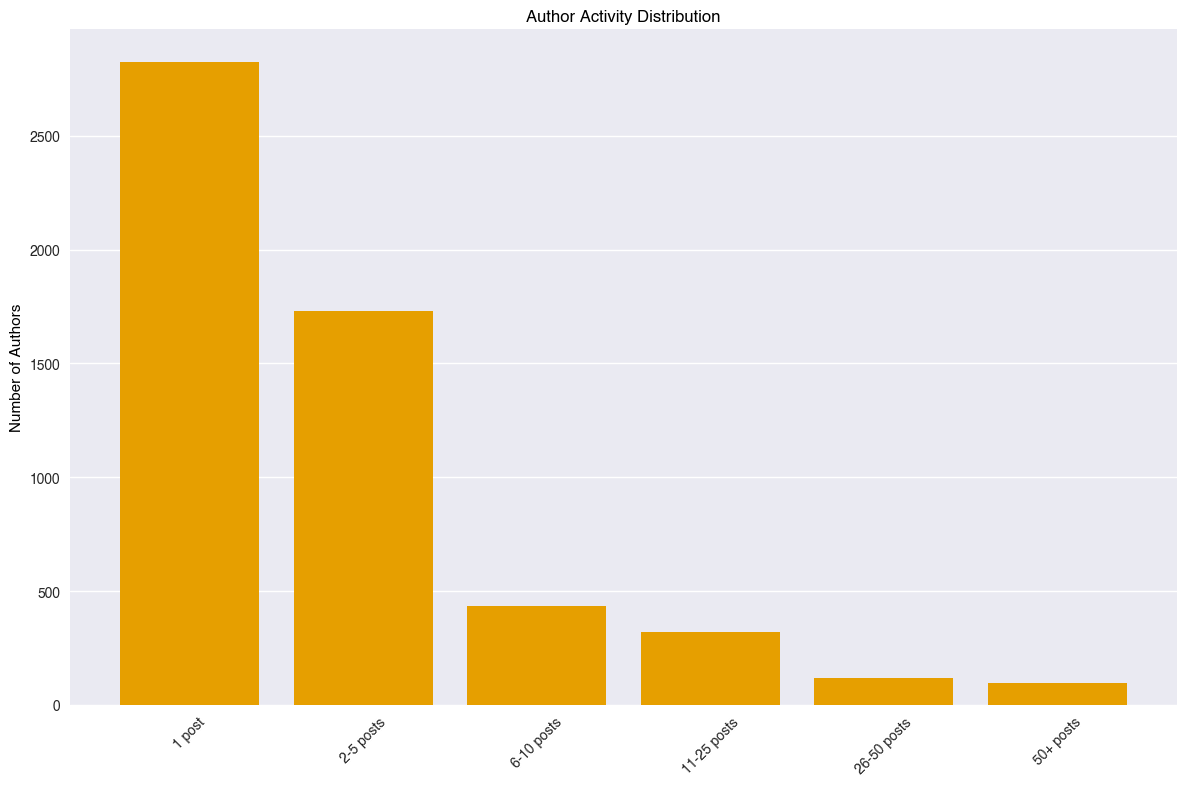

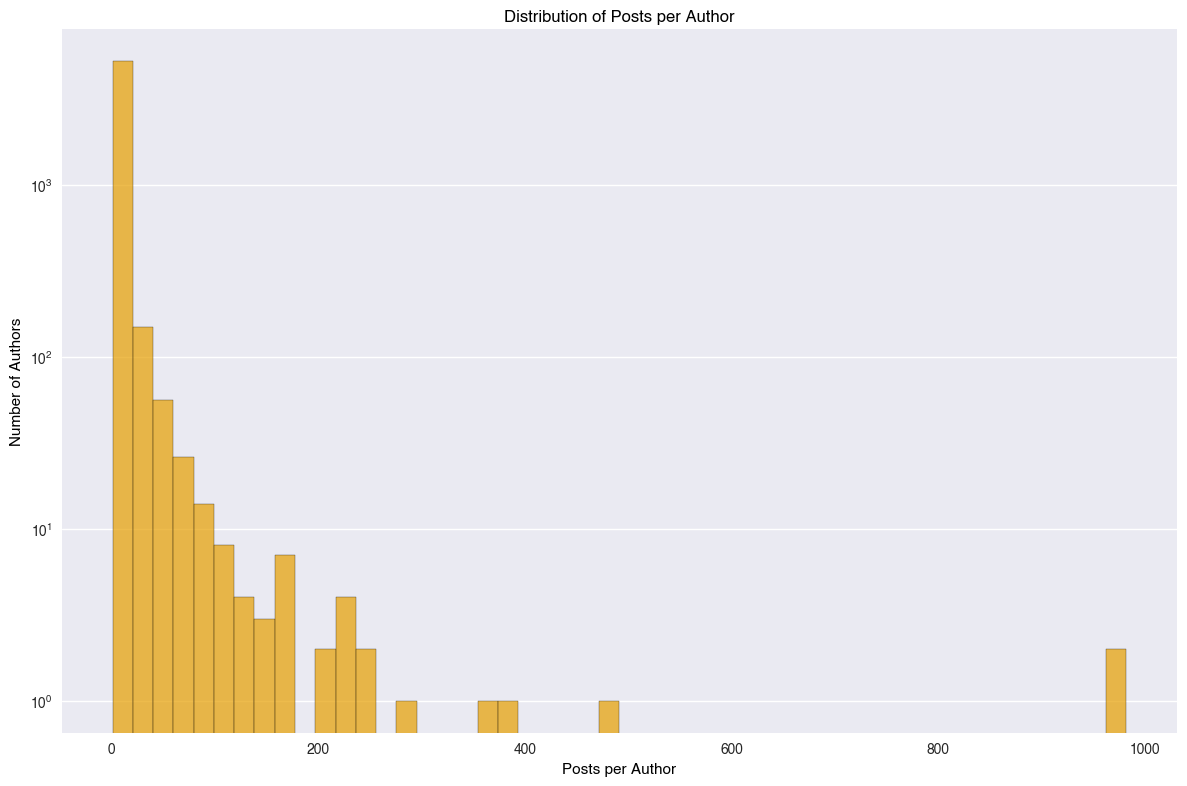

In [51]:
"""Analyze author activity patterns"""
print("\n=== AUTHOR ANALYSIS ===")

author_counts = combined_df['user.username'].value_counts()
print(f"\nTotal unique authors: {len(author_counts):,}")
print(f"Authors with only 1 post: {(author_counts == 1).sum():,} ({((author_counts == 1).sum() / len(author_counts) * 100):.1f}%)")
print(f"Authors with 10+ posts: {(author_counts >= 10).sum():,}")
print(f"Authors with 50+ posts: {(author_counts >= 50).sum():,}")

print(f"\nTop 10 Most Active Authors:")
for author, count in author_counts.head(10).items():
    print(f"{author}: {count} posts")

# Author activity distribution
post_ranges = ['1 post', '2-5 posts', '6-10 posts', '11-25 posts', '26-50 posts', '50+ posts']
counts = [
    (author_counts == 1).sum(),
    ((author_counts >= 2) & (author_counts <= 5)).sum(),
    ((author_counts >= 6) & (author_counts <= 10)).sum(),
    ((author_counts >= 11) & (author_counts <= 25)).sum(),
    ((author_counts >= 26) & (author_counts <= 50)).sum(),
    (author_counts >= 50).sum()
]

plt.bar(post_ranges, counts)
plt.title('Author Activity Distribution')
plt.ylabel('Number of Authors')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig("img/authors_per_number_posts.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Posts per author histogram (log scale)
plt.hist(author_counts.values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Posts per Author')
plt.ylabel('Number of Authors')
plt.title('Distribution of Posts per Author')
plt.yscale('log')
plt.tight_layout()
plt.savefig("img/posts_per_author_histogram.pdf", dpi=300, bbox_inches="tight")
plt.show()



=== TEMPORAL TRENDS ===

Posts by Year:
2016: 1,316 posts
2017: 1,674 posts
2018: 1,842 posts
2019: 2,336 posts
2020: 3,113 posts
2021: 3,474 posts
2022: 4,738 posts
2023: 5,691 posts
2024: 4,648 posts
2025: 4,510 posts


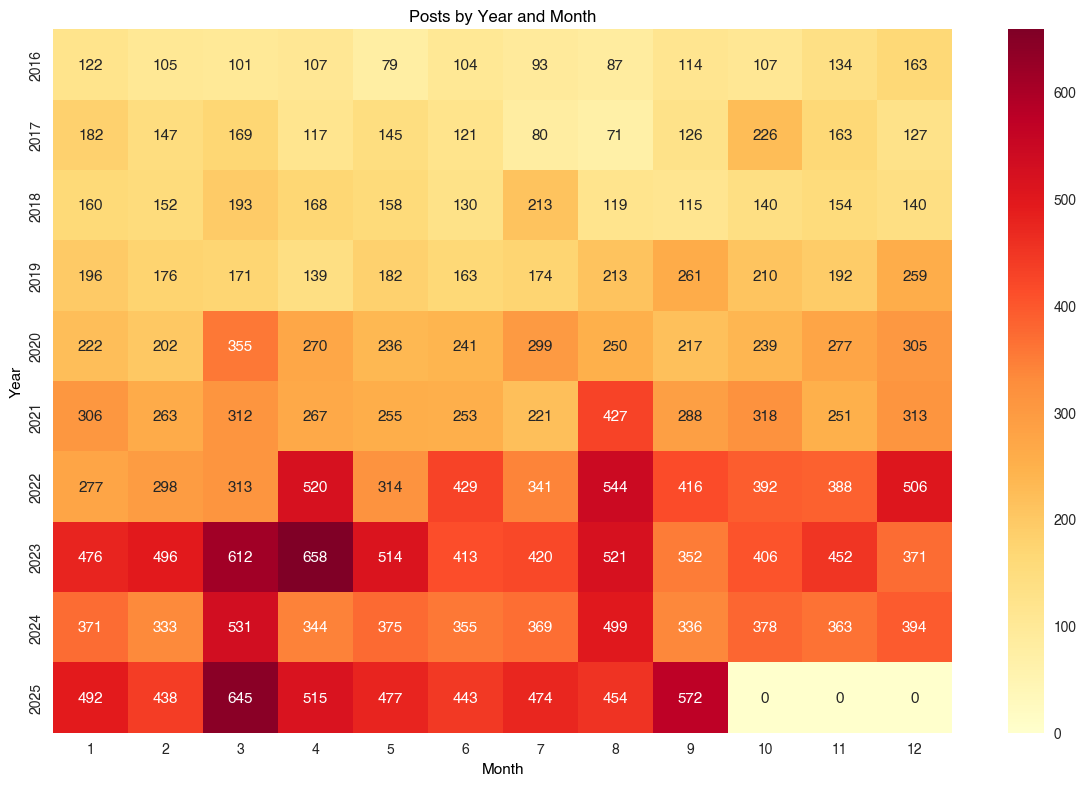

In [52]:
"""Analyze temporal trends"""
print("\n=== TEMPORAL TRENDS ===")

# Posts by year
yearly_posts = combined_df.groupby('year').size()
print(f"\nPosts by Year:")
for year, count in yearly_posts.items():
    print(f"{year}: {count:,} posts")

# Heatmap of posts by year and month
if 'month' in df.columns:
    heatmap_data = combined_df.groupby(['year', 'month']).size().unstack(fill_value=0)
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Posts by Year and Month')
    plt.xlabel('Month')
    plt.ylabel('Year')

plt.tight_layout()
plt.savefig('img/activity_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
"""Generate a comprehensive summary report"""
print("\n" + "="*60)
print("               LESSWRONG DATA SUMMARY REPORT")
print("="*60)

print(f"\n📊 OVERALL STATISTICS:")
print(f"   Total Posts: {len(combined_df):,}")
print(f"   Date Range: {combined_df['year'].min()}-{combined_df['year'].max()}")
print(f"   Unique Authors: {combined_df['user.username'].nunique():,}")
print(f"   Unique Topics: {combined_df['topic_label'].nunique()}")

print(f"\n👥 AUTHOR INSIGHTS:")
author_counts = combined_df['user.username'].value_counts()
print(f"   One-time contributors: {(author_counts == 1).sum():,} ({((author_counts == 1).sum() / len(author_counts) * 100):.1f}%)")
print(f"   Prolific authors (10+ posts): {(author_counts >= 10).sum():,}")
print(f"   Super authors (50+ posts): {(author_counts >= 50).sum():,}")
print(f"   Most prolific: {author_counts.index[0]} with {author_counts.iloc[0]} posts")

print(f"\n🏷️  TOPIC INSIGHTS:")
topic_counts = combined_df['topic_label'].value_counts()
print(f"   Most popular topic: {topic_counts.index[0]} ({topic_counts.iloc[0]:,} posts)")
print(f"   Topics with 100+ posts: {(topic_counts >= 100).sum()}")

print(f"\n🚻 GENDER DISTRIBUTION:")
gender_counts = combined_df['user_gender'].value_counts()
for gender, count in gender_counts.items():
    percentage = (count / len(combined_df)) * 100
    print(f"   {gender.title()}: {count:,} ({percentage:.1f}%)")

print(f"\n📈 ENGAGEMENT METRICS:")
print(f"   Average score: {combined_df['baseScore'].mean():.1f}")
print(f"   Average comments: {combined_df['commentCount'].mean():.1f}")
print(f"   Highest scoring post: {combined_df.loc[combined_df['baseScore'].idxmax(), 'title'][:50]}...")
print(f"   Most commented post: {combined_df.loc[combined_df['commentCount'].idxmax(), 'title'][:50]}...")

print(f"\n📅 TEMPORAL TRENDS:")
yearly_posts = combined_df.groupby('year').size()
peak_year = yearly_posts.idxmax()
print(f"   Peak posting year: {peak_year} with {yearly_posts[peak_year]:,} posts")
print(f"   Growth from {yearly_posts.index[0]} to {yearly_posts.index[-1]}: {((yearly_posts.iloc[-1] / yearly_posts.iloc[0] - 1) * 100):+.1f}%")


               LESSWRONG DATA SUMMARY REPORT

📊 OVERALL STATISTICS:
   Total Posts: 33,342
   Date Range: 2016-2025
   Unique Authors: 5,524
   Unique Topics: 26

👥 AUTHOR INSIGHTS:
   One-time contributors: 2,826 (51.2%)
   Prolific authors (10+ posts): 593
   Super authors (50+ posts): 97
   Most prolific: jkaufman with 982 posts

🏷️  TOPIC INSIGHTS:
   Most popular topic: AI: Emergent Capabilities & Misalignment (4,521 posts)
   Topics with 100+ posts: 26

🚻 GENDER DISTRIBUTION:
   Gm: 20,381 (61.1%)
   -: 10,034 (30.1%)
   Gf: 2,407 (7.2%)

📈 ENGAGEMENT METRICS:
   Average score: 31.5
   Average comments: 10.5
   Highest scoring post: AGI Ruin: A List of Lethalities...
   Most commented post: My experience at and around MIRI and CFAR (inspire...

📅 TEMPORAL TRENDS:
   Peak posting year: 2023 with 5,691 posts
   Growth from 2016 to 2025: +242.7%


Sample of extracted_links:
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

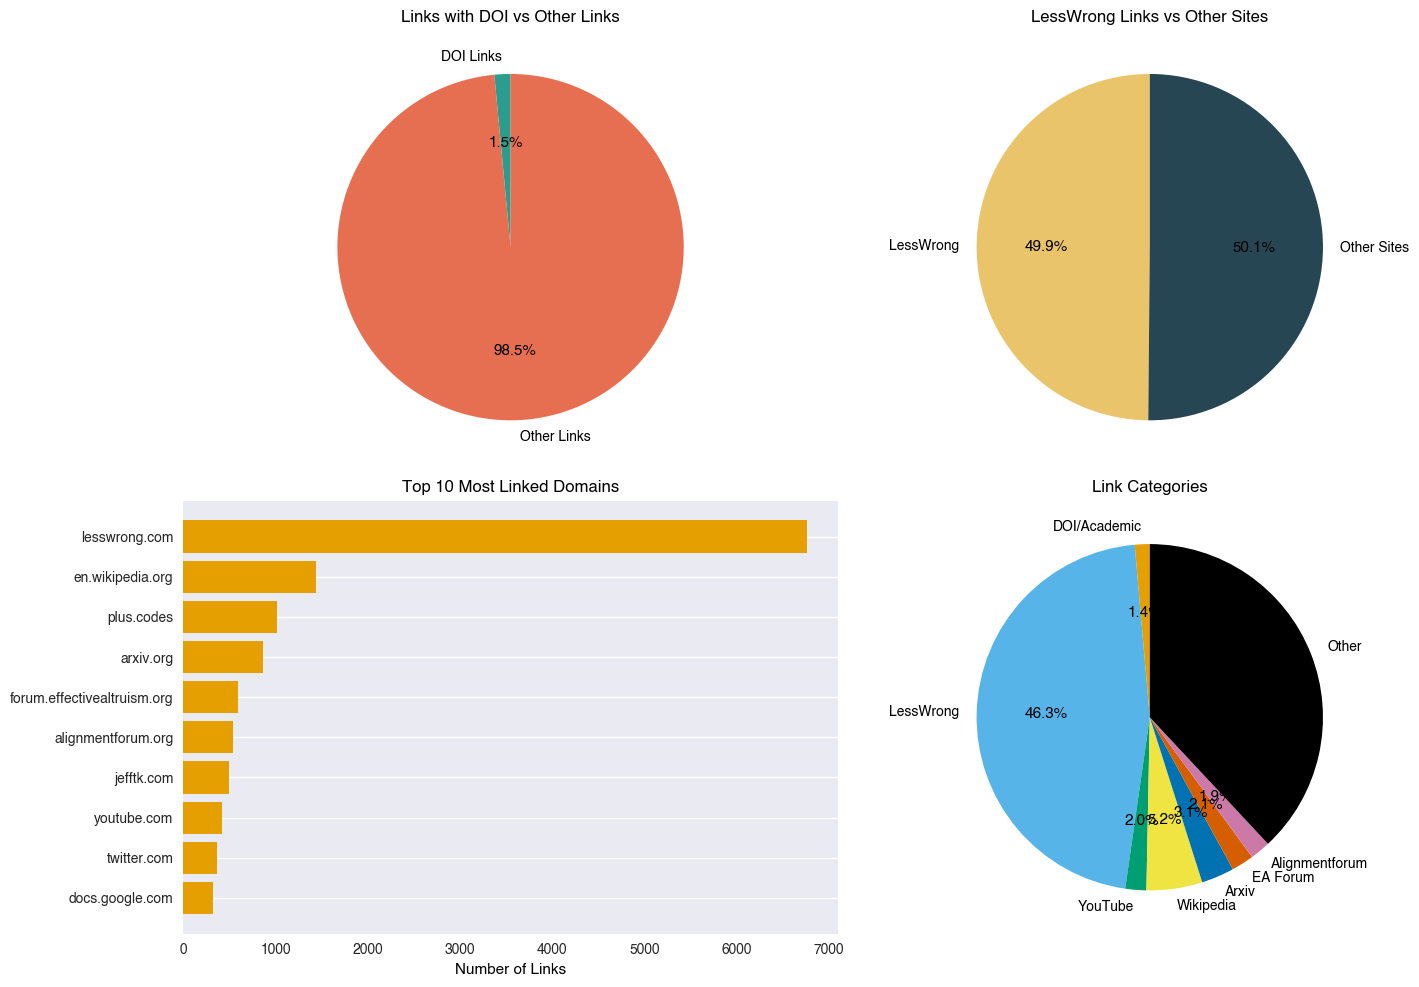


=== ADDITIONAL INSIGHTS ===
YouTube links: 553 (2.1%)
Wikipedia links: 1473 (5.6%)
GitHub links: 379 (1.4%)

=== SAMPLE LINKS FOR VERIFICATION ===
Sample DOI links: ['https://community.fico.com/s/page/a5Q8000000082UQEAY/fico1158; https://community.fico.com/s/blog-post/a5Q2E0000001czyUAA/fico1670; https://paperswithcode.com/sota/fine-grained-image-classification-on-cub-200-1; https://distill.pub/2020/circuits/branch-specialization/; https://distill.pub/2020/circuits/; http://www.incompleteideas.net/IncIdeas/BitterLesson.html; https://doi.org/10.1038/s42256-019-0048-x', 'https://daviskedrosky.substack.com/subscribe?utm_medium=web&utm_source=subscribe-widget&utm_content=65637269; https://daviskedrosky.substack.com/p/twilight-imperium; https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjMlNvuwIH5AhWiKkQIHcZCBnUQFnoECAUQAQ&url=https%3A%2F%2Fonlinelibrary.wiley.com%2Fdoi%2Fabs%2F10.1111%2Fcaje.12065&usg=AOvVaw1WOHH8meaz1Gui2MUbgYse; https://amzn.to/3Pui

In [54]:
print("Sample of extracted_links:")
print(combined_df['extracted_links'].head(10))
print(f"\nTotal rows with links: {combined_df['extracted_links'].notna().sum()}")

all_links = []
for links in combined_df['extracted_links'].dropna():
    if isinstance(links, str):
        # If links are stored as a string, you might need to parse them
        # Adjust this based on how your links are formatted
        if links.startswith('[') and links.endswith(']'):
            # If it's a string representation of a list
            try:
                import ast
                link_list = ast.literal_eval(links)
                all_links.extend(link_list)
            except:
                all_links.append(links)
        else:
            all_links.append(links)
    elif isinstance(links, list):
        all_links.extend(links)
    else:
        all_links.append(str(links))

print(f"Total number of links: {len(all_links)}")

# Clean and analyze links
clean_links = [link.strip() for link in all_links if link and str(link).strip() != '']

# 1. DOI Analysis
doi_pattern = r'(doi:|dx\.doi\.org|doi\.org)'
doi_links = [link for link in clean_links if re.search(doi_pattern, link, re.IGNORECASE)]
doi_count = len(doi_links)

print(f"\n=== DOI ANALYSIS ===")
print(f"Links containing DOI: {doi_count} ({doi_count/len(clean_links)*100:.1f}%)")

# 2. LessWrong Analysis  
lesswrong_links = [link for link in clean_links if 'lesswrong' in link.lower()]
lesswrong_count = len(lesswrong_links)

print(f"\n=== LESSWRONG ANALYSIS ===")
print(f"Links pointing to LessWrong: {lesswrong_count} ({lesswrong_count/len(clean_links)*100:.1f}%)")

# 3. Domain Analysis - Extract domains from all links
def extract_domain(url):
    try:
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url
        parsed = urlparse(url)
        domain = parsed.netloc.lower()
        # Remove www. prefix for cleaner grouping
        if domain.startswith('www.'):
            domain = domain[4:]
        return domain
    except:
        return 'invalid_url'

domains = [extract_domain(link) for link in clean_links]
domain_counts = pd.Series(domains).value_counts()

print(f"\n=== TOP DOMAINS ===")
print("Top 15 domains:")
for domain, count in domain_counts.head(15).items():
    percentage = count/len(clean_links)*100
    print(f"{domain}: {count} links ({percentage:.1f}%)")

# 4. Visualization
plt.figure(figsize=(15, 10))

# Subplot 1: DOI vs Non-DOI
plt.subplot(2, 2, 1)
doi_data = ['DOI Links', 'Other Links']
doi_values = [doi_count, len(clean_links) - doi_count]
plt.pie(doi_values, labels=doi_data, autopct='%1.1f%%', startangle=90,
        colors=["#2a9d8f", "#e76f51"])
plt.title('Links with DOI vs Other Links')

# Subplot 2: LessWrong vs Others
plt.subplot(2, 2, 2)
lw_data = ['LessWrong', 'Other Sites']
lw_values = [lesswrong_count, len(clean_links) - lesswrong_count]
plt.pie(lw_values, labels=lw_data, autopct='%1.1f%%', startangle=90,
        colors=["#e9c46a", "#264653"])
plt.title('LessWrong Links vs Other Sites')

# Subplot 3: Top domains bar chart
plt.subplot(2, 2, 3)
top_domains = domain_counts.head(10)
plt.barh(range(len(top_domains)), top_domains.values)
plt.yticks(range(len(top_domains)), top_domains.index)
plt.xlabel('Number of Links')
plt.title('Top 10 Most Linked Domains')
plt.gca().invert_yaxis()

# Subplot 4: Link type categories
plt.subplot(2, 2, 4)
categories = {
    'DOI/Academic': doi_count,
    'LessWrong': lesswrong_count,
    'YouTube': len([d for d in domains if 'youtube' in d or 'youtu.be' in d]),
    'Wikipedia': len([d for d in domains if 'wikipedia' in d]),
    'Arxiv': len([d for d in domains if 'arxiv' in d]),
    'EA Forum': len([d for d in domains if 'forum.effectivealtruism' in d]),
    'Alignmentforum': len([d for d in domains if 'alignmentforum' in d]),
    'Other': len(clean_links) - doi_count - lesswrong_count - 
             len([d for d in domains if 'youtube' in d or 'youtu.be' in d]) -
             len([d for d in domains if 'wikipedia' in d])
}

plt.pie(categories.values(), labels=categories.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Link Categories')

plt.tight_layout()
plt.savefig("img/link_analysis.pdf", dpi=300, bbox_inches="tight")
plt.show()

# 5. Additional insights
print(f"\n=== ADDITIONAL INSIGHTS ===")
youtube_count = len([d for d in domains if 'youtube' in d or 'youtu.be' in d])
wikipedia_count = len([d for d in domains if 'wikipedia' in d])
github_count = len([d for d in domains if 'github' in d])

print(f"YouTube links: {youtube_count} ({youtube_count/len(clean_links)*100:.1f}%)")
print(f"Wikipedia links: {wikipedia_count} ({wikipedia_count/len(clean_links)*100:.1f}%)")
print(f"GitHub links: {github_count} ({github_count/len(clean_links)*100:.1f}%)")

# Show some example links for verification
print(f"\n=== SAMPLE LINKS FOR VERIFICATION ===")
if doi_links:
    print(f"Sample DOI links: {doi_links[:3]}")
if lesswrong_links:
    print(f"Sample LessWrong links: {lesswrong_links[:3]}")

In [56]:
unknown_gender = combined_df[combined_df["user_gender"] == '-']
print(combined_df["user_gender"])
unknown_gender_counts = unknown_gender['user.username'].value_counts()
# if (unknown_gender_counts < 5).any():
print(unknown_gender_counts.index)
for item in unknown_gender_counts.index:
    print(item)

0         gm
1          -
2          -
3          -
4          -
5         gm
6         gm
7          -
8         gm
9         gm
10        gm
11        gf
12        gm
13        gm
14        gm
15        gm
16        gm
17        gm
18        gm
19        gm
20        gm
21        gm
22        gm
23        gm
24        gf
25        gm
26        gm
27        gm
28        gm
29        gm
30         -
31        gm
32         -
33        gm
34        gm
35         -
36        gm
37         -
38        gm
39         -
40        gm
41         -
42        gm
43        gm
44        gm
45        gm
46        gm
47         -
48        gm
49        gm
50       NaN
51        gm
52         -
53         -
54        gm
55        gm
56        gm
57        gm
58        gm
59        gm
60         -
61        gm
62        gm
63        gm
64        gm
65        gm
66         -
67         -
68        gm
69        gm
70        gm
71        gm
72         -
73        gm
74        gm
75        gm
76        gm